In [47]:
import yfinance as yf 
import sys
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [48]:
import torch.nn as nn


class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


model = StockLSTM()


In [49]:
def load_stock_data(ticker, start, end):
    # Ensure Yahoo Finance-compatible ticker (e.g., Brazilian stocks use .SA)
    yf_ticker = ticker if "." in ticker else f"{ticker}.SA"
    try:
        df = yf.download(yf_ticker, start=start, end=end, auto_adjust=False)[["Close"]]
    except Exception as e:
        raise RuntimeError(f"Failed to download data for {yf_ticker}: {e}")
    if df is None or df.empty:
        raise RuntimeError(f"No data returned for {yf_ticker}. Check the symbol and date range.")
    df.dropna(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

In [50]:
def scale_data(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.values)
    return scaled, scaler

In [51]:
def create_sequences(data, seq_length=50):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [52]:


def load_data( stock = "ABEV3",start: str = "2015-01-01", end: str = "2026-01-01"):
    # 1. Load stock data
    df = load_stock_data(stock, start=start, end=end)
    df.reset_index(inplace=True)

    # 2. Scale the "Close" data
    scaled_data, scaler = scale_data(df[["Close"]])
    df["ScaledClose"] = scaled_data

    # 3. Create input sequences for the model
    X_np, y_np = create_sequences(scaled_data, seq_length=50)

    # Train/test split (e.g., last 20% for test)
    split_idx = int(len(X_np) * 0.8)
    X_train, y_train = X_np[:split_idx], y_np[:split_idx]
    X_test, y_test = X_np[split_idx:], y_np[split_idx:]

    # 4. Convert to PyTorch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)

    # 5. Setup DataLoader
    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 6. Define model, loss, optimizer
    model = StockLSTM(input_size=1, hidden_size=64, num_layers=2)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 7. Train the model
    loss_history = []
    model.train()
    for epoch in range(100):
        epoch_loss = 0.0
        for X_batch, y_batch in loader:
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)

    # 8. Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t).numpy()
        y_true_test = y_test_t.numpy()

    # Inverse transform predictions and truths
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)
    y_true_test_inv = scaler.inverse_transform(y_true_test)

    # Metrics
    mse = float(np.mean((y_true_test - y_pred_test) ** 2))
    mae = float(np.mean(np.abs(y_true_test - y_pred_test)))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs((y_true_test - y_pred_test) / np.clip(y_true_test, 1e-8, None))) * 100)
    # R2 on scaled values
    ss_res = np.sum((y_true_test - y_pred_test) ** 2)
    ss_tot = np.sum((y_true_test - np.mean(y_true_test)) ** 2)
    r2 = float(1 - ss_res / ss_tot) if ss_tot > 0 else float("nan")

    # 9. Predict the next price using last sequence
    with torch.no_grad():
        last_seq = torch.tensor(scaled_data[-50:], dtype=torch.float32).unsqueeze(0)
        predicted_next_scaled = model(last_seq).numpy()
        predicted_next_price = scaler.inverse_transform(predicted_next_scaled)[0][0]

    return {
        "loss_history": [float(l) for l in loss_history],
        "predicted_next_price": float(predicted_next_price),
        "y_true_scaled": y_true_test.squeeze().tolist(),
        "y_pred_scaled": y_pred_test.squeeze().tolist(),
        "y_true": y_true_test_inv.squeeze().tolist(),
        "y_pred": y_pred_test_inv.squeeze().tolist(),
        "metrics": {
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE_%": mape,
            "R2": r2
        },
        "model": model,
        "scaler": scaler
    }

In [53]:
results = load_data(stock="ABEV3.SA", start="2020-01-01", end="2024-12-31")
print("Training completed!")
print("Metrics:")
for k, v in results["metrics"].items():
    print(f"  {k}: {v:.6f}")
print(f"Predicted next price: R$ {results['predicted_next_price']:.2f}")

[*********************100%***********************]  1 of 1 completed

Training completed!
Metrics:
  MSE: 0.000509
  MAE: 0.016033
  RMSE: 0.022553
  MAPE_%: 15.798910
  R2: 0.913135
Predicted next price: R$ 11.99


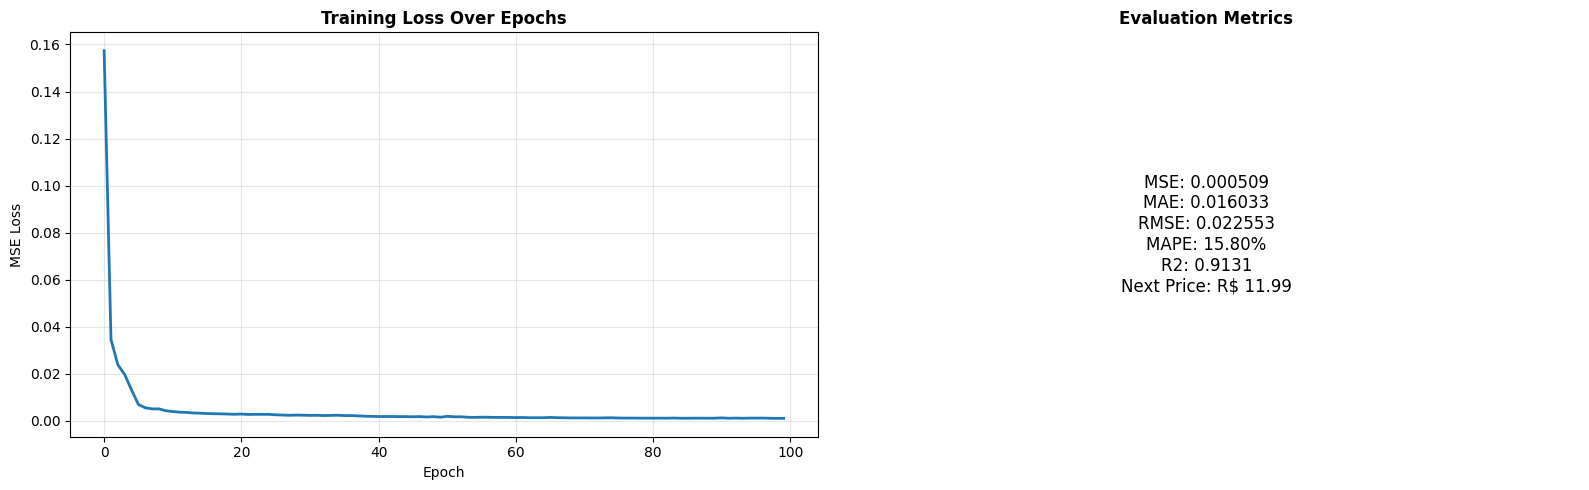

In [54]:
# Plot training loss
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[0].plot(results['loss_history'], linewidth=2)
ax[0].set_title('Training Loss Over Epochs', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE Loss')
ax[0].grid(True, alpha=0.3)

# Metrics summary text
m = results['metrics']
metrics_text = (f"MSE: {m['MSE']:.6f}\n"
                f"MAE: {m['MAE']:.6f}\n"
                f"RMSE: {m['RMSE']:.6f}\n"
                f"MAPE: {m['MAPE_%']:.2f}%\n"
                f"R2: {m['R2']:.4f}\n"
                f"Next Price: R$ {results['predicted_next_price']:.2f}")
ax[1].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12)
ax[1].set_title('Evaluation Metrics', fontsize=12, fontweight='bold')
ax[1].axis('off')

plt.tight_layout()
plt.show()

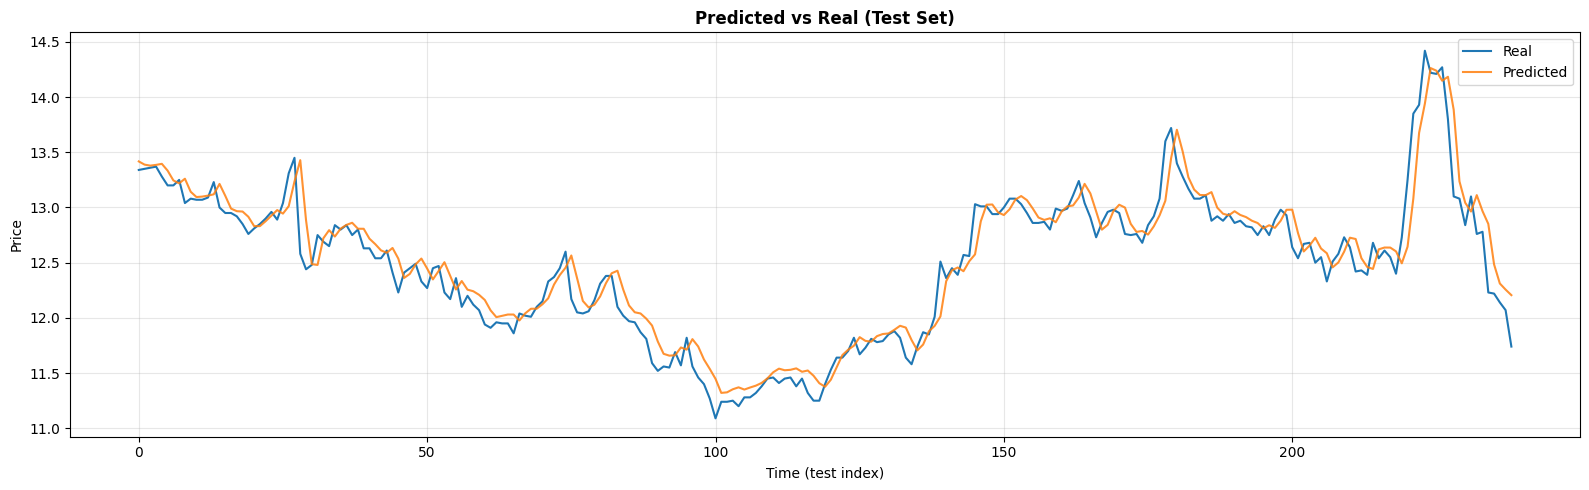

In [55]:
fig, axes = plt.subplots( figsize=(16, 5))

axes.plot(results['y_true'], label='Real', color='tab:blue')
axes.plot(results['y_pred'], label='Predicted', color='tab:orange', alpha=0.85)
axes.set_title('Predicted vs Real (Test Set)', fontsize=12, fontweight='bold')
axes.set_xlabel('Time (test index)')
axes.set_ylabel('Price')
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [56]:
# # Save trained model and scaler (run after training)
# import os, joblib
# os.makedirs("artifacts", exist_ok=True)
# torch.save(results["model"].state_dict(), "artifacts/stock_lstm.pt")
# joblib.dump(results["scaler"], "artifacts/scaler.joblib")
# print("Saved artifacts:", "artifacts/stock_lstm.pt", "artifacts/scaler.joblib")